In [5]:
#Importing libraries
import pandas as pd
import numpy as np
import os
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
import xgboost
import warnings
warnings.filterwarnings('ignore')

In [61]:
#Importing User Defined modules
os.chdir(r'//Users//mac_air//Documents//Documents//Side Projects//Kaggle_Anomaly_Detection//Scripts//')
import ads_creation as ads_crtn
import eda_analysis as eda
import feature_engg as feat_engg
import winsorize as wz
import regression as regr
import clustering as clst
from constants import ATTR, OUTLIER_METHOD, TIME_INVARIANT_ATTR, TIME_VARIANT_ATTR, SPLIT_PCT, IDENTIFIERS

<h1> Helper Functions </h1>

In [7]:
#Funciton to create list of timestamps from first to last
def create_ts_list(df,date_col):
    '''
    This function creates the list of timestamps from first ts to last ts

    Input:
    1. df: pandas dataframe, this is the ads subsetted for one panel
    2. date_col: str, this is the name of the column containing the dates

    Return
    1. dates: pandas dataframe, containing all the timestamps from start to end
    '''
    dates = pd.date_range(start=df[date_col].min(), end = df[date_col].max(),freq = '15min')
    dates = dates.to_frame(index=False)
    dates = dates.rename(columns = {0:'DATE'})
    return dates


In [8]:
#Function to merge in the missing dates in the ADS
def complt_ts(df,date_col):
    '''
    This function introduces the missing time stamps in ads

    Input:
    1. df: pandas dataframe, this is the ads subsetted for one panel
    2. date_col: str, this is the name of the column containing the dates

    Return
    1. df: pandas dataframe, containing all the timestamps from start to end
    '''
    date_list = create_ts_list(df,date_col)
    df = pd.merge(left=date_list,right=df,how='left', on='DATE')
    return df


In [9]:
#Performing data completions at a panel level
def complt_ts_panel_lvl(df,panel_id_col,date_col):
    '''
    This function completes the time stamps for all panels and applies MVT as well

    Input:
    1. df: pandas dataframe, this is the ads for which timestamps need to be completed
    2. panel_id_col: str, the name of the column containing the panel IDs
    3. date_col, str, the name of the column containing the dates

    Returns
    1. df: pandas dataframe, containing all the timestamps from start to end
    '''
    df = df.groupby(panel_id_col).apply(lambda x: complt_ts(x, date_col))
    df = df.reset_index(drop=True)
    df['TIME_OF_DAY'] = df['DATE'].apply(lambda x: 1 if x.hour in range(6,18) else 0)
    #if we dont do this ffill here then the all the obs for inverter ids won't reach
    df[panel_id_col] = df[panel_id_col].ffill()
    df = df.groupby(panel_id_col).apply(lambda x: ads_crtn.missing_value_treatment(x))
    return df


In [10]:
#Function to try different lags, starting from 2 days out till 2 hours and check the accuracy
def get_optimal_lag(train_df,init_lag,pass_threshold,mode,panel_id_col,model_obj,feature_selection=False):
    '''
    This function gets the lag that is most optimal in predicting the target variable
    Either in isolated mode or cumulative mode

    Input:
    1. train_df: pandas dataframe, this is the ads
    2. init_lag: int, the largest lag to begin with
    3. pass_threshold: float, the minimum r-squared values required
    4. mode: str, isolated or cumulative mode
    - Isolated mode: just creates one set of lags and check in silo
    - Cumulative mode: creates a group of lags like 2 day and 1 day lagged variables and checks accuracy together

    Return:
    1. model_dict: python dictionary, this dict contains model objects for each panel
    2. metric_dict: python dictionary, this dict contains error metrics for each panel
    '''

    #Creating a validation df because here we will be choosing the optimal lag
    #this is a form of tuning and test dataset should not be used
    train_df,validation_df = eda.train_test_split(train_df,'INVERTER_ID',0.9)
    r2 = 0
    lag = init_lag
    lag_list = [init_lag]

    #while loop runs till the time the condition is true
    #here we want the loop to stop as soon as one condition is met and the condition to become false
    #if we do or between the two conditions, while loop will still keep running because 0 + 1 = 1 and it will keep running
    #but if we put 'and' then 0 * 1 = 0 and we get the desired result
    while (r2 < pass_threshold) and (lag > 0):
        print('Doing for lag: ',lag)
        train_df_lagged = feat_engg.create_lagged_features(train_df,TIME_VARIANT_ATTR,lag_list,'INVERTER_ID','DATE')
        validation_df_lagged = feat_engg.create_lagged_features(validation_df,TIME_VARIANT_ATTR,lag_list,'INVERTER_ID','DATE')

        features = [feature for feature in train_df_lagged.columns if '_lag_' in feature]
        features = features + TIME_INVARIANT_ATTR
        
        if feature_selection == True:
            features = feat_engg.rfe_feature_selection(train_df_lagged,
                                                RandomForestRegressor(random_state=42),
                                                features,'PER_TS_YIELD')

        models,metrics = regr.panel_wise_model(train_df_lagged,validation_df_lagged,panel_id_col,'PER_TS_YIELD',
                                              model_obj,features=features)
        r2 = metrics[train_df_lagged[panel_id_col].unique()[0]][3]
        print(r2)

        if mode == 'isolated':
            lag -= 8
            lag_list = [lag]
        elif mode == 'cumulative':
            lag -= 8
            lag_list.append(lag)
    return models,metrics


In [11]:
#Perseverence model
def fwd_step_rf_model(train_df,test_df,model_dict,panel_name):
    '''
    This function implements a perseverence model i.e. predicts 15 min in advance then uses that prediction 
    to churn out one more prediction

    Input
    1. train_df: pandas dataframe, training dataset
    2. test_df: pandas dataframe, testing dataset
    3. model_dict: dictionary, dict containing the prediciton models
    4. panel_name: str, string containing panel name for which the model will be run

    Returns:
    1. predicitions: list, which contains the predicitons made for 2 days
    '''
    predictions = []
    scaler = StandardScaler()
    scaler.fit(train_df.values.reshape(-1,1))
    train_df_scaled = scaler.transform(train_df.values.reshape(-1,1))
    pred_obs = train_df_scaled[-1]
    
    for iter in range(len(test_df)):
        if iter == 0:
            pred_obs = model_dict[panel_name].predict(pred_obs.reshape(-1,1))
            predictions.append(pred_obs)
        else:
            pred_obs = model_dict[panel_name].predict(scaler.transform(pred_obs.reshape(-1,1)))
            predictions.append(pred_obs)

    return predictions


In [12]:
#Acutals vs Forecast
def act_vs_fcst(y_true,y_pred,date_series):
    '''
    This function plots actuals vs forecasts

    Input
    1. y_true: pandas series, ground truth
    2. y_pred: pandas series, predictions
    3. date_series: pandas series, series with the dates
    '''
    actual_df = pd.DataFrame({'DATE':date_series, 'Panel':'Actual',
                        'Actual':y_true})
    pred_df = pd.DataFrame({'DATE':date_series, 'Panel':'Predicted',
                        'Predicted':y_pred})

    plot_df = pd.concat([actual_df,pred_df])
    fig = px.line(plot_df,'DATE',['Actual','Predicted'])
    fig.show("svg")

    return


In [13]:
#Function for cleaning data
def remove_anomaly(df):
    '''
    This function removes instances wherein we have irradiation but AC power is 0

    Input:
    1. df: pandas dataframe, dataset containing noise

    Returns:
    df: pandas dataframe, dataset that is clean
    '''
    anam_idx = df.index[(df['IRRADIATION'] != 0) & (df['AC_POWER'] == 0)]
    df = df.drop(anam_idx)
    return df


<h1> Common steps for all Experiments </h1>

In [15]:
#ADS creation, train-test split, outlier treatment
ads = ads_crtn.create_ads()
train_ads, test_ads = eda.train_test_split(ads,'INVERTER_ID',SPLIT_PCT)

#leaving out total yield since it value since it value increase exponentially and rightly so
outlier_feature = [feature for feature in ATTR if feature != 'TOTAL_YIELD'] 
clip_model = wz.winsorize(OUTLIER_METHOD)
clip_model.fit(train_ads[outlier_feature],'INVERTER_ID')
train_ads[outlier_feature] = clip_model.transform(train_ads[outlier_feature])
test_ads[outlier_feature] = clip_model.transform(test_ads[outlier_feature])


<h1> Experiment 1 </h1>

<h2> In this experiment, We will create lagged versions of all our features, wherein all the features would be lagged be 2 days. This way we can use the observations from today and predict 2 days in advance </h2>

In [19]:
#Completing timestamps, so that each panel has all the timestamps from start to finish
train_ads_exp = complt_ts_panel_lvl(train_ads,'INVERTER_ID','DATE')
test_ads_exp = complt_ts_panel_lvl(test_ads,'INVERTER_ID','DATE')

#making ADS stationary
non_stnry_invtr_list = eda.return_non_stnry_invtr_list(train_ads_exp,'INVERTER_ID')
train_ads = eda.make_ads_stnry(train_ads_exp,non_stnry_invtr_list,'INVERTER_ID','DATE')

non_stnry_invtr_list = eda.return_non_stnry_invtr_list(test_ads_exp,'INVERTER_ID')
test_ads = eda.make_ads_stnry(test_ads_exp,non_stnry_invtr_list,'INVERTER_ID','DATE')

#Creating lagged features which are lagged by exactly 2 days so that they can then be used for prediction

train_ads_exp = feat_engg.create_lagged_features(train_ads_exp,TIME_VARIANT_ATTR,[192],'INVERTER_ID','DATE')
test_ads_exp = feat_engg.create_lagged_features(test_ads_exp, TIME_VARIANT_ATTR, [192], 'INVERTER_ID','DATE')

features = [feature + '_lag_192' for feature in TIME_VARIANT_ATTR]
features = features + TIME_INVARIANT_ATTR

models,metrics = regr.panel_wise_model(train_ads_exp,test_ads_exp,
                                        'INVERTER_ID','PER_TS_YIELD',
                                        RandomForestRegressor(random_state=42),
                                        features=features)


low_acc_invtr = [(key,metrics[key][3]) for key in metrics.keys() if metrics[key][3] < 0.8]
invtr_list = [val_pair[0] for val_pair in low_acc_invtr]
print(low_acc_invtr)


Modelling for panel: 1BY6WEcLGh8j5v7
Modelling for panel: 1IF53ai7Xc0U56Y
Modelling for panel: 3PZuoBAID5Wc2HD
Modelling for panel: 4UPUqMRk7TRMgml
Modelling for panel: 7JYdWkrLSPkdwr4
Modelling for panel: 81aHJ1q11NBPMrL
Modelling for panel: 9kRcWv60rDACzjR
Modelling for panel: Et9kgGMDl729KT4
Modelling for panel: IQ2d7wF4YD8zU1Q
Modelling for panel: LYwnQax7tkwH5Cb
Modelling for panel: LlT2YUhhzqhg5Sw
Modelling for panel: McdE0feGgRqW7Ca
Modelling for panel: Mx2yZCDsyf6DPfv
Modelling for panel: NgDl19wMapZy17u
Modelling for panel: PeE6FRyGXUgsRhN
Modelling for panel: Qf4GUc1pJu5T6c6
Modelling for panel: Quc1TzYxW2pYoWX
Modelling for panel: V94E5Ben1TlhnDV
Modelling for panel: VHMLBKoKgIrUVDU
Modelling for panel: WRmjgnKYAwPKWDb
Modelling for panel: WcxssY2VbP4hApt
Modelling for panel: YxYtjZvoooNbGkE
Modelling for panel: ZnxXDlPa8U1GXgE
Modelling for panel: ZoEaEvLYb1n2sOq
Modelling for panel: adLQvlD726eNBSB
Modelling for panel: bvBOhCH3iADSZry
Modelling for panel: iCRJl6heRkivqQ3
M

<h3> From the above experiment we saw that we are having a lot of trouble predicting for the plant 4136001 </h3>

<h1> Experiment 2 </h1>

<h2> Performing rfecv based on RF on the panels that gave poor accuracy in the previous step. So, that the significant variables may increase the accuracy </h2>

In [26]:
metrics_rfe = {}
for invertor in invtr_list[0:2]:
    feat_set = feat_engg.rfe_feature_selection(train_ads_exp.loc[train_ads_exp['INVERTER_ID']==invertor,],
                                                RandomForestRegressor(random_state=42),
                                                features,'PER_TS_YIELD')
    
    models,metrics = regr.panel_wise_model(train_ads_exp.loc[train_ads_exp['INVERTER_ID']==invertor,],
                                            test_ads_exp.loc[test_ads_exp['INVERTER_ID']==invertor,],
                                            'INVERTER_ID',
                                            'PER_TS_YIELD',
                                            RandomForestRegressor(random_state=42),
                                            features=feat_set)
    print('Added metric for :',invertor)
    metrics_rfe[invertor] = metrics[invertor]

Modelling for panel: 4UPUqMRk7TRMgml
Added metric for : 4UPUqMRk7TRMgml
Modelling for panel: 81aHJ1q11NBPMrL
Added metric for : 81aHJ1q11NBPMrL


<h2> Performed this experiment on only 2 panels, for faster execution. Got very poor accuracy with rfecv as well </h2>

In [27]:
print(metrics_rfe)

{'4UPUqMRk7TRMgml': (4.326853129624277e+16, 37.53757785149787, 4943.14573812595, 0.17794791444964098), '81aHJ1q11NBPMrL': (7572704869083764.0, 19.43481130301415, 1373.9470594817508, 0.7900208030075239)}


<h1> Experiment 3 </h1>

<h2> Finding the most optimal lag starting from 2 days to 15 min. To further use in perseverence model </h2>

In [33]:
#Finding the lag which gives the best accuracy, starting from 2 days out and moving closer to t-1
#All the different lags are looked at in isolation or cumulatively
#conducting this experiment with only one panel, if successful only then will scale up to other panels

trial_df = train_ads.loc[train_ads['INVERTER_ID']==invtr_list[1],]

#running it in isolated mode first
try_model,try_metric = get_optimal_lag(trial_df,192,0.8,'isolated',
                                        'INVERTER_ID',
                                        RandomForestRegressor(random_state=42),False)

#running the pipeline in cumulative mode
#better performance as compared to before but still did not cross 80% on validation dataset

#Commenting the below piece of code, since it takes a lot of time on local system
#try_model,try_metric = get_optimal_lag(trial_df,192,0.8,'cumulative')


Doing for lag:  192
Modelling for panel: 81aHJ1q11NBPMrL
0.5403374834985144
Doing for lag:  184
Modelling for panel: 81aHJ1q11NBPMrL
0.5573963338307616
Doing for lag:  176
Modelling for panel: 81aHJ1q11NBPMrL
0.5348747537337651
Doing for lag:  168
Modelling for panel: 81aHJ1q11NBPMrL
0.6013769807535917
Doing for lag:  160
Modelling for panel: 81aHJ1q11NBPMrL
0.7104338049132781
Doing for lag:  152
Modelling for panel: 81aHJ1q11NBPMrL
0.614042967113398
Doing for lag:  144
Modelling for panel: 81aHJ1q11NBPMrL
0.6627574786524694
Doing for lag:  136
Modelling for panel: 81aHJ1q11NBPMrL
0.6606524107354759
Doing for lag:  128
Modelling for panel: 81aHJ1q11NBPMrL
0.6444101939834361
Doing for lag:  120
Modelling for panel: 81aHJ1q11NBPMrL
0.6410439520929543
Doing for lag:  112
Modelling for panel: 81aHJ1q11NBPMrL
0.7285484694291637
Doing for lag:  104
Modelling for panel: 81aHJ1q11NBPMrL
0.7624680070227596
Doing for lag:  96
Modelling for panel: 81aHJ1q11NBPMrL
0.6468233173819998
Doing for lag:

<h2> Did not receive good results with this as well, no lag was able to give more than 80% accuracy </h2>

<h1> Experiment 4 </h1>

<h2> Tried to get optimal lag with feature selection & ran the code on google colab. It took a lot of time and did not give favorable results </h2>

<h1> Experiment 5 </h1>

<h2>Perseverence model</h2>
<h2>Forecast only 15 min in advance and use that forecast as input and forecast for another 15 min</h2>

In [40]:
#Creating lagged version of target variable 
train_ads_exp = feat_engg.create_lagged_features(train_ads,['PER_TS_YIELD'],[1],'INVERTER_ID','DATE')
test_ads_exp = feat_engg.create_lagged_features(test_ads, ['PER_TS_YIELD'], [1], 'INVERTER_ID','DATE')

features = [feature for feature in train_ads_exp.columns if '_lag_' in feature]

models,metrics = regr.panel_wise_model(train_ads_exp,test_ads_exp,
                                        'INVERTER_ID','PER_TS_YIELD',
                                        RandomForestRegressor(random_state=42),features=features)

low_acc_invtr = [(key,metrics[key][3]) for key in metrics.keys() if metrics[key][3] < 0.8]
invtr_list = [val_pair[0] for val_pair in low_acc_invtr]

#Persevernce Model
fwd_models = {}
for invtr in invtr_list:
    print('Modelling for panel: ',invtr)
    preds = fwd_step_rf_model(train_ads_exp.loc[train_ads_exp['INVERTER_ID'] == invtr,features],
                            test_ads_exp.loc[test_ads_exp['INVERTER_ID'] == invtr,features],
                            models,invtr)


    y_pred = [prediction for sublist in preds for prediction in sublist]

    r2 = r2_score(test_ads_exp.loc[test_ads_exp['INVERTER_ID'] == invtr,'PER_TS_YIELD'],y_pred)
    fwd_models[invtr] = r2


Modelling for panel: 1BY6WEcLGh8j5v7
Modelling for panel: 1IF53ai7Xc0U56Y
Modelling for panel: 3PZuoBAID5Wc2HD
Modelling for panel: 4UPUqMRk7TRMgml
Modelling for panel: 7JYdWkrLSPkdwr4
Modelling for panel: 81aHJ1q11NBPMrL
Modelling for panel: 9kRcWv60rDACzjR
Modelling for panel: Et9kgGMDl729KT4
Modelling for panel: IQ2d7wF4YD8zU1Q
Modelling for panel: LYwnQax7tkwH5Cb
Modelling for panel: LlT2YUhhzqhg5Sw
Modelling for panel: McdE0feGgRqW7Ca
Modelling for panel: Mx2yZCDsyf6DPfv
Modelling for panel: NgDl19wMapZy17u
Modelling for panel: PeE6FRyGXUgsRhN
Modelling for panel: Qf4GUc1pJu5T6c6
Modelling for panel: Quc1TzYxW2pYoWX
Modelling for panel: V94E5Ben1TlhnDV
Modelling for panel: VHMLBKoKgIrUVDU
Modelling for panel: WRmjgnKYAwPKWDb
Modelling for panel: WcxssY2VbP4hApt
Modelling for panel: YxYtjZvoooNbGkE
Modelling for panel: ZnxXDlPa8U1GXgE
Modelling for panel: ZoEaEvLYb1n2sOq
Modelling for panel: adLQvlD726eNBSB
Modelling for panel: bvBOhCH3iADSZry
Modelling for panel: iCRJl6heRkivqQ3
M

In [42]:
print(fwd_models['4UPUqMRk7TRMgml'])

-0.6633902466590609


<h2> Printed the accuracy for an example panel, like this panel most panels have negative r-squared. So this experiment also failed miserably </h2>

<h1> Experiment 6</h1>

<h2> Making a XGBoost model for all the panels that did not perform well in Experiment 1</h2>

In [46]:
model = xgboost.XGBRegressor(random_state=42)

train_ads_exp_xgb = train_ads_exp.loc[train_ads_exp['INVERTER_ID'].isin(invtr_list),]
test_ads_exp_xgb = test_ads_exp.loc[test_ads_exp['INVERTER_ID'].isin(invtr_list),]
models_xgb,metrics_xgb = regr.panel_wise_model(train_ads_exp_xgb,test_ads_exp_xgb,'INVERTER_ID','PER_TS_YIELD',model,features=features)

low_acc_invtr = [(key,metrics_xgb[key][3]) for key in metrics_xgb.keys() if metrics_xgb[key][3] < 0.8]
invtr_list = [val_pair[0] for val_pair in low_acc_invtr]

Modelling for panel: 4UPUqMRk7TRMgml
Modelling for panel: 81aHJ1q11NBPMrL
Modelling for panel: 9kRcWv60rDACzjR
Modelling for panel: Et9kgGMDl729KT4
Modelling for panel: IQ2d7wF4YD8zU1Q
Modelling for panel: LYwnQax7tkwH5Cb
Modelling for panel: LlT2YUhhzqhg5Sw
Modelling for panel: Mx2yZCDsyf6DPfv
Modelling for panel: NgDl19wMapZy17u
Modelling for panel: PeE6FRyGXUgsRhN
Modelling for panel: Qf4GUc1pJu5T6c6
Modelling for panel: Quc1TzYxW2pYoWX
Modelling for panel: V94E5Ben1TlhnDV
Modelling for panel: WcxssY2VbP4hApt
Modelling for panel: mqwcsP2rE7J0TFp
Modelling for panel: oZ35aAeoifZaQzV
Modelling for panel: oZZkBaNadn6DNKz
Modelling for panel: q49J1IKaHRwDQnt
Modelling for panel: rrq4fwE8jgrTyWY
Modelling for panel: vOuJvMaM2sgwLmb
Modelling for panel: xMbIugepa2P7lBB
Modelling for panel: xoJJ8DcxJEcupym


In [52]:
low_acc_invtr

[('4UPUqMRk7TRMgml', 0.6292445942538605),
 ('81aHJ1q11NBPMrL', 0.7868701922328022),
 ('9kRcWv60rDACzjR', 0.6881906758338177),
 ('Et9kgGMDl729KT4', 0.5481710064195193),
 ('IQ2d7wF4YD8zU1Q', 0.6802121843180808),
 ('LYwnQax7tkwH5Cb', 0.7466097151649751),
 ('LlT2YUhhzqhg5Sw', 0.6474269372899065),
 ('Mx2yZCDsyf6DPfv', 0.5481390048306423),
 ('NgDl19wMapZy17u', 0.6290449609232556),
 ('PeE6FRyGXUgsRhN', 0.6384321055522699),
 ('Qf4GUc1pJu5T6c6', 0.49948199898439416),
 ('Quc1TzYxW2pYoWX', 0.5631789140620491),
 ('V94E5Ben1TlhnDV', 0.5462637332850718),
 ('WcxssY2VbP4hApt', 0.6981603828109741),
 ('mqwcsP2rE7J0TFp', 0.5306353286007349),
 ('oZ35aAeoifZaQzV', 0.5208670652235265),
 ('oZZkBaNadn6DNKz', 0.6119874662936554),
 ('q49J1IKaHRwDQnt', 0.6294021671596782),
 ('rrq4fwE8jgrTyWY', 0.7049013348577101),
 ('vOuJvMaM2sgwLmb', 0.6530707958343396),
 ('xMbIugepa2P7lBB', 0.6017791973048432),
 ('xoJJ8DcxJEcupym', 0.7188121142529869)]

<h2> Even the above XGBoost regressor is not giving good accuracy </h2>

<h1> Experiment 7 </h1>

<h2> Making a model at a plant level, moving away from panel level models </h2>

In [56]:
#Completing timestamps, so that each panel has all the timestamps from start to finish
train_ads_exp = complt_ts_panel_lvl(train_ads,'INVERTER_ID','DATE')
test_ads_exp = complt_ts_panel_lvl(test_ads,'INVERTER_ID','DATE')

train_ads_exp = feat_engg.create_lagged_features(train_ads_exp,TIME_VARIANT_ATTR,[192],'INVERTER_ID','DATE')
test_ads_exp = feat_engg.create_lagged_features(test_ads_exp, TIME_VARIANT_ATTR, [192], 'INVERTER_ID','DATE')

features = [feature + '_lag_192' for feature in TIME_VARIANT_ATTR]
features = features + TIME_INVARIANT_ATTR

models,metrics = regr.panel_wise_model(train_ads_exp,test_ads_exp,
                                        'PLANT_ID','PER_TS_YIELD',
                                        RandomForestRegressor(random_state=42),
                                        features=features)

Modelling for panel: 4135001.0
Modelling for panel: 4136001.0


In [57]:
print(metrics)

{4135001.0: (2110184295403390.5, 9.528655815352526, 431.08177540851773, 0.9502300616253726), 4136001.0: (3.46672801548629e+16, 23.0250729005699, 2596.127669491405, 0.5676923389093932)}


<h2> Getting good accuracy for plant 1, but very low for plant 2 </h2>

<h1> Experiment 8 </h1>

<h2>Clustering within plant 4136001 and making a model for each cluster</h2>

In [63]:
train_ads_clst = train_ads.loc[train_ads['PLANT_ID']==4136001.0].reset_index(drop=True)
test_ads_clst = test_ads.loc[test_ads['PLANT_ID']==4136001.0].reset_index(drop=True)

#running the below loop to give us the number of clusters that are optimal for this clustering exercise
#10 clusters are coming out to be most optimal, so lets go ahead witthat

n_clust = clst.get_n_clusters(train_ads_clst.loc[:,~train_ads_clst.columns.isin(IDENTIFIERS)],2,11)

#kmeans clustering with 10 clusters
clusterer = KMeans(n_clusters=n_clust, random_state=42)
cluster_labels = clusterer.fit_predict(train_ads_clst.loc[:,~train_ads_clst.columns.isin(IDENTIFIERS)])

train_ads_clst = pd.concat([pd.DataFrame({'CLUSTER_ID':list(cluster_labels)}),train_ads_clst],axis=1)

#putting the cluster IDs in the test ads as well
invtr_clst_map = train_ads_clst[['INVERTER_ID','CLUSTER_ID']].drop_duplicates().reset_index(drop=True)
test_ads_clst = pd.merge(test_ads_clst,invtr_clst_map,on='INVERTER_ID',how='inner')



Score for clusters # 2 is 0.9237337352666161
Score for clusters # 3 is 0.9469246931954871
Score for clusters # 4 is 0.9714336995109856
Score for clusters # 5 is 0.9654832407059628
Score for clusters # 6 is 0.9736857033951449
Score for clusters # 7 is 0.9752411142358455
Score for clusters # 8 is 0.9753780585879965
Score for clusters # 9 is 0.9753360598735886
Score for clusters # 10 is 0.9761359403841954


In [64]:
#Making model for each cluster
train_ads_clst = feat_engg.create_lagged_features(train_ads_clst,TIME_VARIANT_ATTR,[192],'INVERTER_ID','DATE')
test_ads_clst = feat_engg.create_lagged_features(test_ads_clst, TIME_VARIANT_ATTR, [192], 'INVERTER_ID','DATE')

features = [feature + '_lag_192' for feature in TIME_VARIANT_ATTR]
features = features + TIME_INVARIANT_ATTR

models,metrics = regr.panel_wise_model(train_ads_clst,test_ads_clst,
                                        'CLUSTER_ID','PER_TS_YIELD',
                                        RandomForestRegressor(random_state=42),
                                        features=features)

Modelling for panel: 0
Modelling for panel: 6
Modelling for panel: 4
Modelling for panel: 5
Modelling for panel: 8
Modelling for panel: 9
Modelling for panel: 2
Modelling for panel: 7
Modelling for panel: 3
Modelling for panel: 1


In [65]:
print(metrics)

{0: (2.628998144319603e+16, 27.786231701629692, 2712.8494544427967, 0.5328980131660274), 6: (0.45442635223657124, 52.25236758396752, 8367.601654580638, -0.48433007298095787), 4: (4.411904340429865e+16, 25.905848051267174, 2557.7726250933206, 0.5533857588366069), 5: (0.4591950810508664, 53.61316377887385, 8657.902484738175, -0.4969924521310036), 8: (8.05120991721603e+16, 64.75253363698896, 9054.365573525314, -0.6941721311281099), 9: (1.0589652216885698e+17, 58.90866803746859, 5879.36791660955, -0.07113558897316752), 2: (3.5311324033680916e+16, 22.57945297847288, 2520.8058891124747, 0.5317340523797776), 7: (0.45740623013350284, 52.30514939605849, 8251.632549268912, -0.4959981726988576), 3: (2.9155413867814176e+16, 21.54439928425358, 2218.816587772368, 0.6259230248165947), 1: (3.9391924568561784e+16, 23.50990804546393, 2595.1806073154034, 0.5060402576430512)}


<h2> Even one model for each cluster is not giving good accuracy, will have to move onto something else </h2>

<h1> Experiment 9 </h1>

<h2> Trying to find optimal lag while making a model at a plant level </h2>

In [69]:
train_ads_exp = train_ads.loc[train_ads['PLANT_ID']==4136001.0].reset_index(drop=True)
test_ads_exp = test_ads.loc[test_ads['PLANT_ID']==4136001.0].reset_index(drop=True)

_,metrics = get_optimal_lag(train_ads_exp,192,0.8,'isolated','PLANT_ID',RandomForestRegressor(random_state=42))


Doing for lag:  192
Modelling for panel: 4136001.0
0.6262299972358314
Doing for lag:  184
Modelling for panel: 4136001.0
0.5744545527198623
Doing for lag:  176
Modelling for panel: 4136001.0
0.5447193459943611
Doing for lag:  168
Modelling for panel: 4136001.0
0.5264043339349596
Doing for lag:  160
Modelling for panel: 4136001.0
0.5860152989568388
Doing for lag:  152
Modelling for panel: 4136001.0
0.5591530025298104
Doing for lag:  144
Modelling for panel: 4136001.0
0.5794610540418403
Doing for lag:  136
Modelling for panel: 4136001.0
0.5553368176870389
Doing for lag:  128
Modelling for panel: 4136001.0
0.5779158006118967
Doing for lag:  120
Modelling for panel: 4136001.0
0.5940232154046461
Doing for lag:  112
Modelling for panel: 4136001.0
0.6125081135367787
Doing for lag:  104
Modelling for panel: 4136001.0
0.5797327665302299
Doing for lag:  96
Modelling for panel: 4136001.0
0.5972764717112247
Doing for lag:  88
Modelling for panel: 4136001.0
0.589873379926956
Doing for lag:  80
Mode

<h2> No luck with different lags when modelling for the entire panel as well </h2>

<h1> Experiment 10 </h1>

<h2> Removing the noise from the data in which we no AC power even when the Irradiation is non zero </h2>

In [74]:
    train_ads_exp = remove_anomaly(train_ads)
    test_ads_exp = remove_anomaly(test_ads)

    train_ads_exp = complt_ts_panel_lvl(train_ads_exp,'INVERTER_ID','DATE')
    test_ads_exp = complt_ts_panel_lvl(test_ads_exp,'INVERTER_ID','DATE')

    train_ads_exp = feat_engg.create_lagged_features(train_ads_exp,TIME_VARIANT_ATTR,[192],'INVERTER_ID','DATE')
    test_ads_exp = feat_engg.create_lagged_features(test_ads_exp, TIME_VARIANT_ATTR, [192], 'INVERTER_ID','DATE')

    features = [feature + '_lag_192' for feature in TIME_VARIANT_ATTR]
    features = features + TIME_INVARIANT_ATTR + ['TIME_OF_DAY']
    
    models,metrics = regr.panel_wise_model(train_ads_exp,test_ads_exp,
                                        'PLANT_ID','PER_TS_YIELD',
                                        RandomForestRegressor(random_state=42),
                                        features=features)

Modelling for panel: 4135001.0
Modelling for panel: 4136001.0


In [75]:
metrics

{4135001.0: (89748041563183.84,
  9.092884662248307,
  330.3089217584814,
  0.9617233009728813),
 4136001.0: (5543222780623540.0,
  14.91597963612078,
  1151.247352927607,
  0.802378953867604)}

<h2> With this denoised dataset, our random forest model finally comes good and we get 80% + accuracy on both the data sets </h2>

<h2> Plotting Actuals vs Predicted for a panel from plant 4135001 </h2>

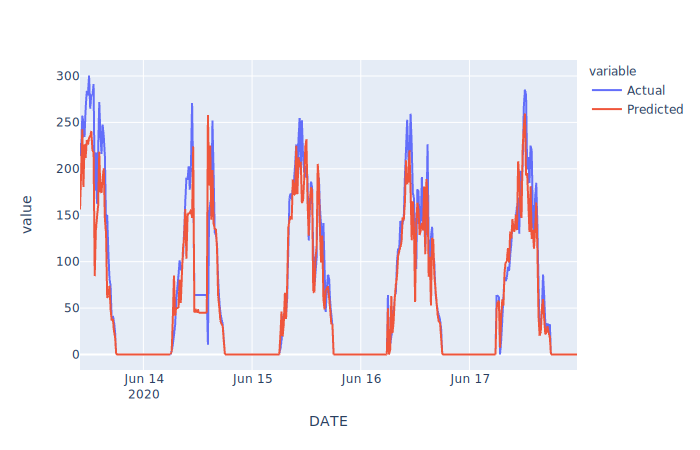

In [88]:
scaler = StandardScaler()
scaler.fit(train_ads_exp.loc[train_ads_exp['PLANT_ID'] == 4135001,features])

train_df_scaled = scaler.transform(train_ads_exp.loc[train_ads_exp['PLANT_ID'] == 4135001,features])
test_df_scaled = scaler.transform(test_ads_exp.loc[test_ads_exp['PLANT_ID'] == 4135001, features])

panel_idx = test_ads_exp.index[test_ads_exp['INVERTER_ID'] == '1BY6WEcLGh8j5v7']

y_pred = models[4135001].predict(test_df_scaled[panel_idx])

act_vs_fcst(test_ads_exp.loc[panel_idx,'PER_TS_YIELD'], y_pred, test_ads_exp.loc[panel_idx,'DATE'])

<h2> As we can see the model is able to very well capture the variation present in the data </h2>

<h2> Plotting Actuals vs Predicted for a panel from plant 4136001 </h2>

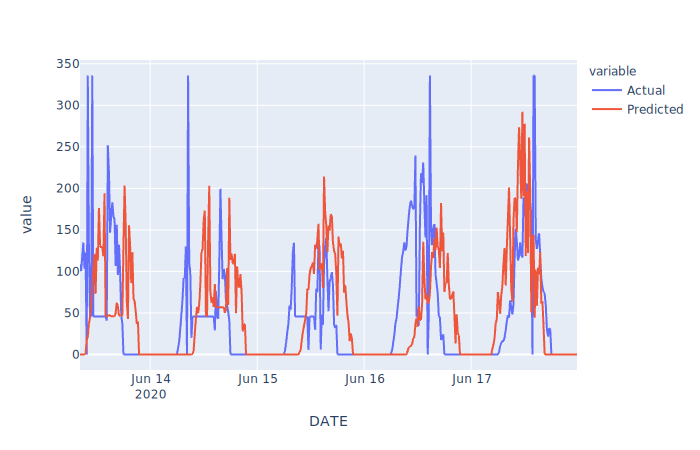

In [91]:
scaler = StandardScaler()
scaler.fit(train_ads_exp.loc[train_ads_exp['PLANT_ID'] == 4136001,features])

train_df_scaled = scaler.transform(train_ads_exp.loc[train_ads_exp['PLANT_ID'] == 4136001,features])
test_df_scaled = scaler.transform(test_ads_exp.loc[test_ads_exp['PLANT_ID'] == 4136001, features])

panel_idx = test_ads_exp.index[test_ads_exp['INVERTER_ID'] == 'Qf4GUc1pJu5T6c6']

y_pred = models[4136001].predict(test_df_scaled[panel_idx])

act_vs_fcst(test_ads_exp.loc[panel_idx,'PER_TS_YIELD'], y_pred, test_ads_exp.loc[panel_idx,'DATE'])

<h2> Here as well our model does well, but not quite as good as plant 1 model. We can try and squeze out more performance, but we will stop here for now </h2>